# Data Science Task 2

This is a segmentation task that uses company sales data as the data basis. In this task, customers are to be divided into segments based on their purchasing behavior (customer segmentation). The main task is to identify relevant patterns in the purchasing behavior of customers. Several segmentation solutions are possible. The ones of particular importance to the company are those that are associated with a gain in customer insight, with implications for revenue and profit growth.

In general, a customer segmentation is carried out so that customers can be addressed in a targeted manner or in order to offer suitable products and services to the customer. **Meaningful** differentiation criteria for the company would be the customer price sensitivity, the assortment mix (similarity of the articles purchased by the customer), seasonal buying behavior of the customer, etc.

## Goal of this task

Write a small program that divides customers into customer groups based on their purchasing behavior. Use a suitable, respectively preferred programming language (Python, Matlab, R) or library. You are welcome to use notebooks (e.g., Jupyter Notebook) for the purpose of writing and documenting your code.

For this task several solutions are possible. Therefore, it is important to document the program code. A logging of a progress, function and error report provides extra points in evaluation.
Use company sales data as data basis.

# Scores:

- Final segmentation of customers. The code should be clean, understandable and sufficiently commented. (**50 points**)

- Adequate comments and user instructions. All necessary means (e.g. extra libraries to be installed) to run the program (**10 points**).

- Graphical representation and interpretation of the final solution (your created customer segmentation) (**15 points**)

- Logging of your progress, function and error report (**25 points**)

Total **100 points**

In [204]:
%matplotlib inline
import os
import glob
import numpy as np
import seaborn as sns

from datetime import datetime
import locale
locale.setlocale(locale.LC_ALL, "german")

from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from pyclustertend import hopkins

# 1. Data Cleaning & Exploratory Data Analysis

## Import Modules, Load Data & Data Review

In [229]:
### Import factura data as data frame ###
# The file "DataScienceAufgabe2_FacturaData" is located in folder "/DataScienceAufgabe2/Data/".
# In order to use it in jupyter notebook you have to upload it (See "Upload" Button in http://localhost:8889/tree) )

factura_df = pd.read_csv("DataScienceAufgabe2_FacturaData.csv", encoding="iso-8859-1", decimal=",", sep=";")
# Get column overview
factura_df.dtypes

customerNumber                           int64
purchaseDate                            object
branchNumber                             int64
articleNumber                            int64
quantity                               float64
discountOnRecommendedRetailPrice[%]    float64
purchaseAmount                         float64
dtype: object

In [230]:
factura_df.head()

,customerNumber,purchaseDate,branchNumber,articleNumber,quantity,discountOnRecommendedRetailPrice[%],purchaseAmount
0,557,2021-01-04,19,6013,1.00,0.00,17.24
1,557,2021-01-04,19,6663,2.00,8.37,94.96
2,189,2021-01-04,17,2982,2.00,32.23,59.96
3,490,2021-01-04,19,10658,1.00,25.04,24.05
4,896,2021-01-04,36,14971,3.00,0.00,26.69


In [231]:
factura_df.describe().T

,count,mean,std,min,25%,50%,75%,max
customerNumber,718987.00,509.37,287.25,1.00,253.00,522.00,746.00,1000.00
branchNumber,718987.00,48.62,29.36,1.00,25.00,42.00,74.00,101.00
articleNumber,718987.00,10418.54,6267.80,1.00,4730.00,10207.00,15982.00,21088.00
quantity,718987.00,15.63,89.42,0.00,1.00,2.00,6.00,13013.00
discountOnRecommendedRetailPrice[%],718987.00,3.53,10.93,0.00,0.00,0.00,0.00,100.00
purchaseAmount,718987.00,123.19,244.96,0.03,21.29,51.96,128.63,24728.52


Here we can roughly analyze the data distribution. There are no negative values for quantity in the data set. It can be concluded that the data set does not indicate order cancellation. 

In [232]:
def summary(factura_df, pred=None):
    obs = factura_df.shape[0]
    Types = factura_df.dtypes
    Counts = factura_df.apply(lambda x: x.count())
    Min = factura_df.min()
    Max = factura_df.max()
    Uniques = factura_df.apply(lambda x: x.unique().shape[0])
    Nulls = factura_df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

display(summary(factura_df).sort_values(by='Nulls', ascending=False))

Data shape: (718987, 1)
___________________________
Data Types:
int64      3
float64    3
object     1
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
articleNumber,int64,718987,21063,0,1,21088
branchNumber,int64,718987,101,0,1,101
customerNumber,int64,718987,1000,0,1,1000
discountOnRecommendedRetailPrice[%],float64,718987,7733,0,0.00,100.00
purchaseAmount,float64,718987,26282,0,0.03,24728.52
purchaseDate,object,718987,307,0,2021-01-02,2021-12-31
quantity,float64,718987,1296,0,0.00,13013.00


The number of unique values of the features is important. Reducing the number of unique values is an optimisation technique used to improve the performance of artificial intelligence algorithms. The number of rows is 718987 for this data set. Unique values close to this value can be evaluated in this context.

The purchaseAmount and customerNumber variables are float64. These variables can be converted from float64 to int16 to reduce the calculation cost.

In [233]:
factura_df.customerNumber = factura_df.customerNumber.astype('int16')
factura_df.purchaseAmount = factura_df.purchaseAmount.astype('int16')

In [234]:
factura_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718987 entries, 0 to 718986
Data columns (total 7 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   customerNumber                       718987 non-null  int16  
 1   purchaseDate                         718987 non-null  object 
 2   branchNumber                         718987 non-null  int64  
 3   articleNumber                        718987 non-null  int64  
 4   quantity                             718987 non-null  float64
 5   discountOnRecommendedRetailPrice[%]  718987 non-null  float64
 6   purchaseAmount                       718987 non-null  int16  
dtypes: float64(2), int16(2), int64(2), object(1)
memory usage: 30.2+ MB


## Handling Missing Values

In [235]:
factura_df.isnull().sum()

customerNumber                         0
purchaseDate                           0
branchNumber                           0
articleNumber                          0
quantity                               0
discountOnRecommendedRetailPrice[%]    0
purchaseAmount                         0
dtype: int64

There are no null values in our data set. To optimize the use of machine learning algorithms, null values can be droped if available. 

In [236]:
factura_df.duplicated().value_counts()

False    702601
True      16386
dtype: int64

There are 16364 duplicate data in the data set. It was evaluated that the same customer bought the same product several times on the same day. Duplicate data is not dropped for this reason.

## Grouping data for the purpose of presentation from different perspectives

In [237]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
factura_df.groupby("customerNumber").purchaseAmount.sum().sort_values(ascending=False)

customerNumber
676   2621826.00
323    517780.00
53     457325.00
147    443293.00
824    363968.00
         ...    
641     24678.00
132     20934.00
226     19930.00
144     18855.00
705     14618.00
Name: purchaseAmount, Length: 1000, dtype: float64

<AxesSubplot:xlabel='customerNumber'>

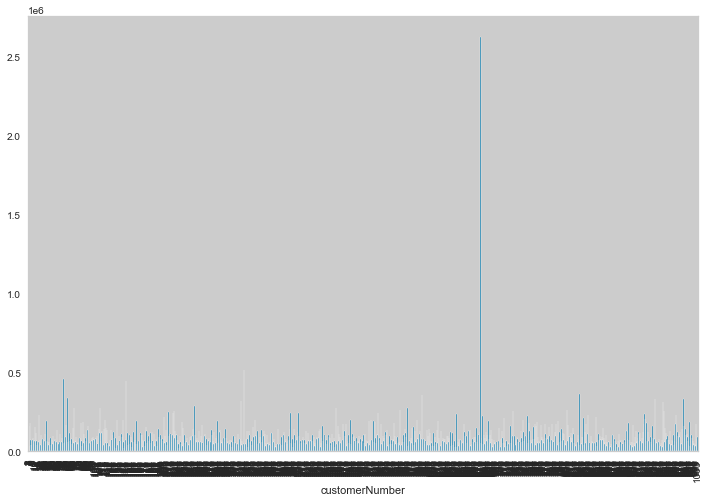

In [238]:
plt.figure(figsize=(12,8))
factura_df.groupby("customerNumber").purchaseAmount.sum().plot(kind="bar")

Where the totals of the purchase amount are grouped by customers. The top ten customers who make the most purchases can be an important piece of information.

In [239]:
factura_df.groupby("customerNumber").articleNumber.nunique().mean()

267.789

This value show us the average number of unqiue items per customer.

In [240]:
factura_df.groupby("customerNumber").articleNumber.nunique()

customerNumber
1       224
2       200
3       299
4       214
5       159
       ... 
996     189
997     250
998     285
999     199
1000    270
Name: articleNumber, Length: 1000, dtype: int64

In [ ]:
You can see number of unqiue items per customer.

In [241]:
factura_df.groupby('articleNumber').quantity.sum().sort_values(ascending=False)

articleNumber
163     716621.00
11019   233998.00
18953   159875.00
17619   135311.00
19096   130907.00
           ...   
10855        0.02
7958         0.02
20111        0.02
18738        0.01
4472         0.01
Name: quantity, Length: 21063, dtype: float64

In [242]:
factura_df.groupby(['articleNumber']).agg({ 'quantity': lambda x:x.sum()}).sort_values('quantity', ascending=False).head()

,quantity
articleNumber,
163,716621.00
11019,233998.00
18953,159875.00
17619,135311.00
19096,130907.00


Here the products sold in the highest number are determined.

In [243]:
#the products that bring the highest turnover
factura_df.groupby(['articleNumber']).agg({ 'purchaseAmount': lambda x:x.sum()}).sort_values('purchaseAmount', ascending=False).head()

,purchaseAmount
articleNumber,
20677,862832
2259,794726
13377,576840
3469,495437
8169,483839


We can see the products that bring the highest turnover have been identified.

In [133]:
display(factura_df.articleNumber[20677])

12304

In [138]:
display(factura_df.iloc[12302])

customerNumber                                219
purchaseDate                           2021-07-05
branchNumber                                   43
articleNumber                               20677
quantity                                    15.00
discountOnRecommendedRetailPrice[%]          0.00
purchaseAmount                                317
Name: 12302, dtype: object

In [35]:
factura_df.head()

,customerNumber,purchaseDate,branchNumber,articleNumber,quantity,discountOnRecommendedRetailPrice[%],purchaseAmount
0,557,2021-01-04,19,6013,1.00,0.00,17.24
1,557,2021-01-04,19,6663,2.00,8.37,94.96
2,189,2021-01-04,17,2982,2.00,32.23,59.96
3,490,2021-01-04,19,10658,1.00,25.04,24.05
4,896,2021-01-04,36,14971,3.00,0.00,26.69


# 2. RFM Analysis

In the age of the internet and e-commerce, companies that do not expand their businesses online or utilize digital tools to reach their customers will run into issues like scalability and a lack of digital precsence. An important marketing strategy e-commerce businesses use for analyzing and predicting customer value is customer segmentation. Customer data is used to sort customers into group based on their behaviors and preferences.

**[RFM](https://www.putler.com/rfm-analysis/) (Recency, Frequency, Monetary) Analysis** is a customer segmentation technique for analyzing customer value based on past buying behavior. RFM analysis was first used by the direct mail industry more than four decades ago, yet it is still an effective way to optimize your marketing.
<br>
<br>
Our goal in this Notebook is to cluster the customers in our data set to:
 - Recognize who are our most valuable customers
 - Increase revenue
 - Increase customer retention
 - Learn more about the trends and behaviors of our customers
 - Define customers that are at risk

We will start with **RFM Analysis** and then compliment our findings with predictive analysis using **K-Means Clustering Algorithms.**

- RECENCY (R): Time since last purchase
- FREQUENCY (F): Total number of purchases
- MONETARY VALUE (M): Total monetary value




Benefits of RFM Analysis

- Increased customer retention
- Increased response rate
- Increased conversion rate
- Increased revenue

RFM Analysis answers the following questions:
 - Who are our best customers?
 - Who has the potential to be converted into more profitable customers?
 - Which customers do we need to retain?
 - Which group of customers is most likely to respond to our marketing campaign?

In [244]:
#Finding min and max days. The date of the first and last purchase is determined for RFM analysis.
print('Min:{}; Max:{}'.format(min(factura_df.purchaseDate), max(factura_df.purchaseDate)))

Min:2021-01-02; Max:2021-12-31


In [245]:
# Pivot date is found. One day after from max date so it is 2022-01-01.  
import datetime
NOW = datetime.datetime(2022,1,1)

There are different approaches to the choice of pivot date. One day after the last purchase date or today's date. After analysing similar studies, one day later was chosen. Because a period of one and a half years has passed since the last purchase.

In [246]:
#For RFM analysis, purchasedate format is converted from string to integer with the datetime function.
factura_df['purchaseDate'] =  pd.to_datetime(factura_df['purchaseDate'])

In [247]:
#Finding Recency, Frequency und Monetary Values and Creating a dataframe (rfm) for rfm analysis
rfm = factura_df.groupby(['customerNumber']).agg({
    'purchaseDate': lambda x: (NOW - x.max()).days,
    'articleNumber': 'count',
    'purchaseAmount': 'sum'})

# Rename the columns 
rfm.rename(columns={'purchaseDate': 'Recency',
                         'articleNumber': 'Frequency',
                         'purchaseAmount': 'MonetaryValue'}, inplace=True)
rfm.sample(7)

,Recency,Frequency,MonetaryValue
customerNumber,,,
220,5,1138,128741.00
10,9,932,65678.00
196,11,732,92962.00
454,12,583,111354.00
64,1,440,80129.00
399,2,474,52477.00
838,2,574,35689.00


### Plot RFM Distributions

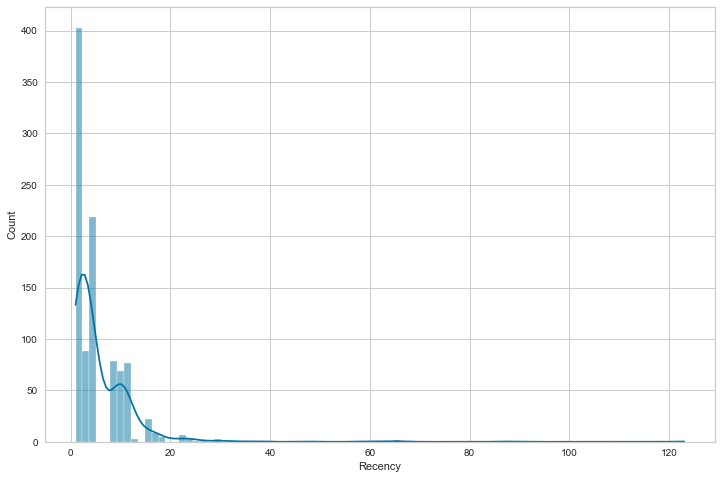

In [248]:
# After calculating the days since last purchase, RFM distribution for recency has been drawn. Most of the purchases have taken place in the last month.
plt.figure(figsize = (12,8))
sns.histplot(rfm.Recency, kde=True);

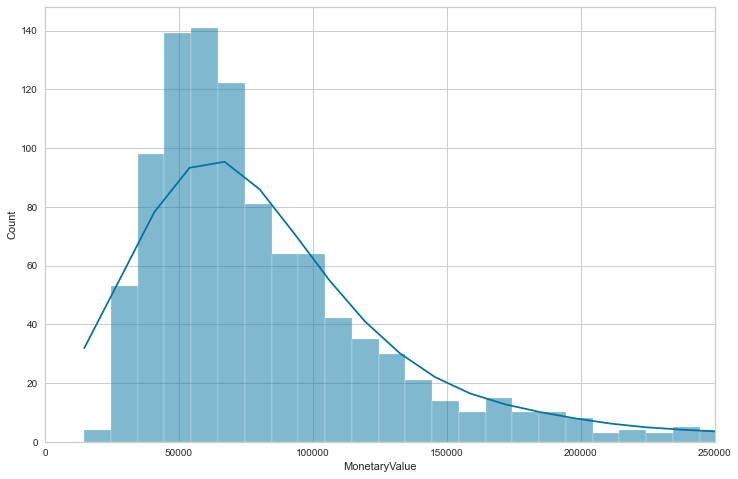

In [249]:
#RFM distribution for monetary values has been drawn. Most of the amount of purchases have taken place between 50000-100000.
plt.figure(figsize = (12,8))
sns.histplot(rfm.MonetaryValue, kde=True)
plt.xlim(0,250000);

### Calculating RFM Scores

In [250]:
#Creating 4 division for rfm levels

r_labels = range(4, 0,-1); f_labels = range(1, 5); m_labels = range(1, 5)

r_groups = pd.qcut(rfm['Recency'], q=4, labels=r_labels)

f_groups = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)

m_groups = pd.qcut(rfm['MonetaryValue'], q=4, labels=m_labels)

rfm = rfm.assign(R=r_groups.values, F=f_groups.values, M=m_groups.values)

rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

We divide the customer segment into 4 groups. We want to analyse these four groups. In this context, R, F and M scores are found and RFM score is calculated from their sum.

In [251]:
rfm.head(5)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
customerNumber,,,,,,,
1,3,465,162812.00,3,1,4,8
2,3,425,33578.00,3,1,1,5
3,11,1351,178882.00,1,4,4,9
4,2,423,72461.00,4,1,3,8
5,11,436,38888.00,1,1,1,3


In [252]:
#RFM score data segment is divided into 4 groups. 'Low', 'Middle', 'High', 'Top Class' labels are assigned to the groups.
score_labels = ['Low', 'Middle', 'High', "Top Class"]
score_groups = pd.qcut(rfm.RFM_Score, q = 4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values

rfm.sample(5)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Level
customerNumber,,,,,,,,
901,4,635,58899.00,3,3,2,8,Middle
283,2,1662,191334.00,4,4,4,12,Top Class
939,4,493,53613.00,3,2,2,7,Middle
202,10,740,67712.00,1,3,2,6,Low
256,2,1156,126151.00,4,4,4,12,Top Class


As seen above, each customer receives R, F and M values. A customer with 4 points from each of them is Top Class.
- RFM score, which is the sum of R, F and M scores, was used in this evaluation. There are studies using classification techniques using only R and F scores. There are techniques that average this value or write it side by side (such as 111, 424). 

In [253]:
#The mean and counts of R, F and M scores according to RFM levels were analysed.
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(1)
print(rfm_level_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low          9.80    476.60      50643.70   322
Middle       4.90    580.60      71787.90   279
High         4.10    802.90     107579.40   257
Top Class    2.00   1388.50     170663.80   142


### Plot RFM Segments

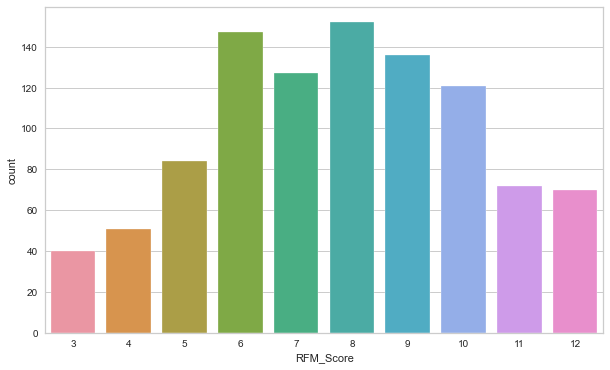

In [254]:
plt.figure(figsize = (10,6))
sns.countplot(x= 'RFM_Score', data = rfm);

This graph shows how many customers get how many points. The highest number of customers scored 8 points.

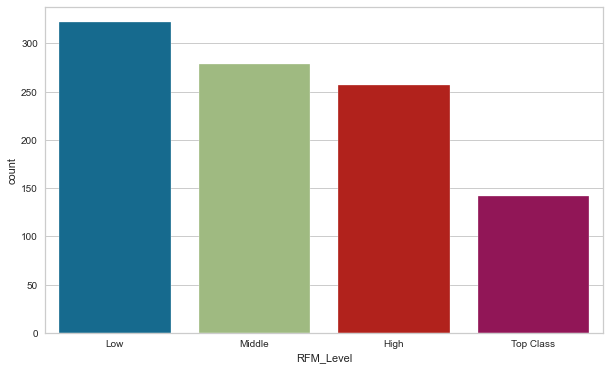

In [255]:
plt.figure(figsize = (10,6))
sns.countplot(x= 'RFM_Level', data = rfm);

This graph shows us the number of customers according to RFM level. The high number of customers (low) that can be lost is noticeable. It is critical to develop a strategy for this.

# 3. Applying K-Means Clustering

Now that we have our customers segmented into 6 different categories, we can gain further insight into customer behavior by using predictive models in conjuction with out RFM model.
Possible algorithms include **Logistic Regression**, **K-means Clustering**, and **K-nearest Neighbor**. We will go with [K-Means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) since we already have our distinct groups determined. K-means has also been widely used for market segmentation and has the advantage of being simple to implement.

In [256]:
# A new data frame is created with only R, F and M columns of the RFM data frame.
rfm_df=rfm.loc[:,["Recency" , "Frequency", "MonetaryValue"]]
rfm_df.sample(5)

,Recency,Frequency,MonetaryValue
customerNumber,,,
126,2,548,63612.00
580,3,1015,74323.00
121,1,705,45885.00
955,1,1073,94508.00
473,5,619,126446.00


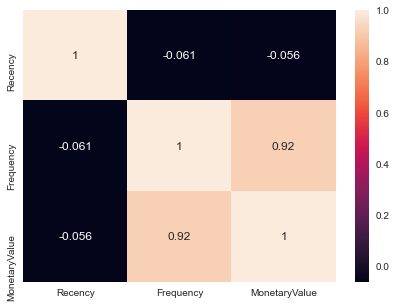

In [257]:
#here the correlation matrix with heatmap was analysed.
plt.figure(figsize = (7,5))
sns.heatmap(rfm_df.corr(), annot = True);

A correlation coefficient of +0.92 means that there is a strong positive correlation between Frequency and MonetaryValue. There is weak negative correlation between Recency and Frequency / MonetaryValue.

C:\Users\Taner\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Taner\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Taner\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

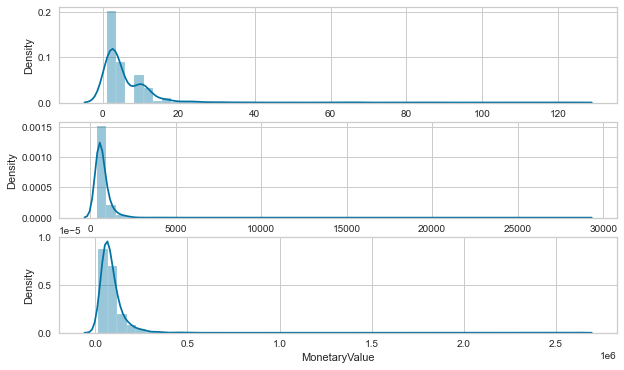

In [258]:
#The general distribution is drawn with distplot.
plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1); sns.distplot(rfm_df.Recency)
plt.subplot(3, 1, 2); sns.distplot(rfm_df.Frequency)
plt.subplot(3, 1, 3); sns.distplot(rfm_df.MonetaryValue)
plt.show()

Distribution of Recency, Frequency and Monetary; they are all right skewed.

## Using the logarithm method to normalize the values in a column.

A Shapiro test is performed to see if the data set is normally distributed. p value is checked. If p value > 0.05, the data is normally distributed. 

In [259]:
a = list(rfm_df["Recency"])

In [260]:
shapiro_test_r = stats.shapiro(a)
shapiro_test_r

ShapiroResult(statistic=0.5125426650047302, pvalue=0.0)

In [261]:
b = list(rfm_df["Frequency"])

In [262]:
shapiro_test_f = stats.shapiro(b)
shapiro_test_f

ShapiroResult(statistic=0.16990190744400024, pvalue=0.0)

In [263]:
c = list(rfm_df["MonetaryValue"])

In [264]:
shapiro_test_m = stats.shapiro(c)
shapiro_test_m

ShapiroResult(statistic=0.33967071771621704, pvalue=0.0)

Data is normally distributed if the significance in these tests is p > 0.05. pvalue: 0.0 < 0.05 so distribution of data for Recency, Frequency and Monetary are not normally distributed. 

Logarithm transformation can be used to convert the data set into a normal distribution.

In [265]:
# 1 is added to prevent null data in the new data set.
rfm_log = np.log(rfm_df+1)

In [266]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)

rfm_normalized = scaler.transform(rfm_log)

rfm_normalized = pd.DataFrame(data=rfm_normalized, index=rfm_df.index, columns=rfm_df.columns)

In [267]:
rfm_normalized.sample(5)

,Recency,Frequency,MonetaryValue
customerNumber,,,
470,-0.75,-1.10,-0.04
124,1.33,1.26,1.09
439,1.33,0.52,0.23
326,-0.75,-0.08,0.15
693,1.09,-0.26,0.15


In [268]:
rfm_normalized2=rfm_normalized.copy()

In [269]:
rfm_normalized.agg(["mean", "std"]).round()

,Recency,Frequency,MonetaryValue
mean,0.00,0.00,0.00
std,1.00,1.00,1.00


In a standard normal distribution, mean equals 0 and std equals 1. 

C:\Users\Taner\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Taner\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Taner\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

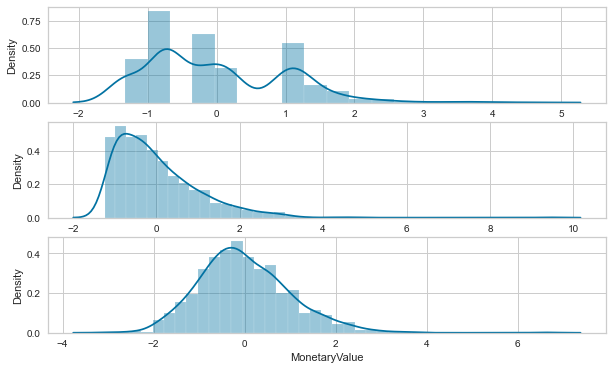

In [270]:
plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1); sns.distplot(rfm_normalized.Recency)
plt.subplot(3, 1, 2); sns.distplot(rfm_normalized.Frequency)
plt.subplot(3, 1, 3); sns.distplot(rfm_normalized.MonetaryValue)
plt.show()

<Figure size 720x504 with 0 Axes>

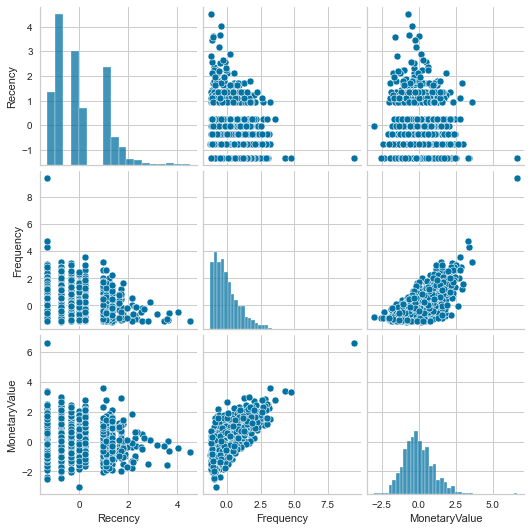

In [271]:
# Here Scatter and histograms were observed with pairplot. Histograms were checked to be close to normal distribution.
plt.figure(figsize = (10,7))
sns.pairplot(rfm_normalized);

## K-Means Implementation

For k-means, you have to set k to the number of clusters you want, but figuring out how many clusters is not obvious from the beginning. We will try different cluster numbers and check their silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar).

Note: K-means is sensitive to initializations because they are critical to qualifty of optima found. Thus, we will use smart initialization called "Elbow Method".

### Define the Optimal Number of Clusters

In [272]:
# Hopkins a statistical test have made.
hopkins(rfm_normalized, rfm_normalized.shape[0])

0.05284507538627509

- Hopkins test, a statistical test for randomness of a variable. In order to make a cluster, the data must be randomly distributed.
- The more close 0, the more available to seperate clusters. 0.5 value can be as threshold. (0.052 < 0.5)

In [273]:
rfm_normalized.head()

,Recency,Frequency,MonetaryValue
customerNumber,,,
1,-0.34,-0.77,1.47
2,-0.34,-0.99,-1.47
3,1.21,1.86,1.64
4,-0.75,-1.01,-0.04
5,1.21,-0.93,-1.20


In [274]:
from sklearn.cluster import KMeans
sse={}
for k in range(1,15):
    kmeans = KMeans(n_clusters=k, random_state=101)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_

C:\Users\Taner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


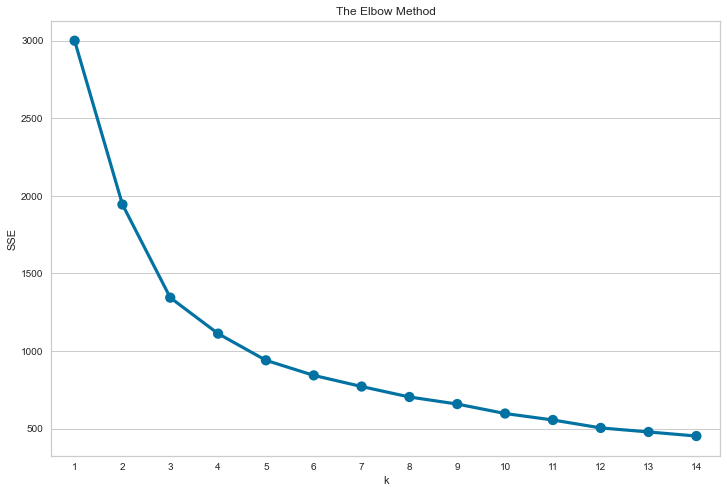

In [275]:
# Elbow method is used to decide the optimum number of clusters.
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
sns.set_style("darkgrid")
plt.show()

- Elbow method; the sum of the squares of the distances of the points to the cluster centre according to each K value is calculated. According to these values, a graph is drawn for each K value. The elbow point on the graph where the difference between the sums starts to decrease is determined as the most appropriate K value. 
From the graph above, it is evaluated that k can be 3 and 4. 

### Yellowbrick Method

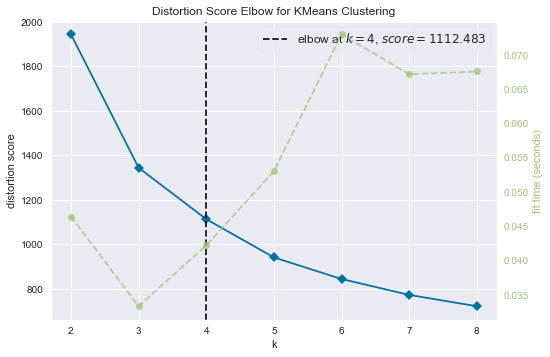

In [276]:
# The yellowbrick method was also used to ensure the optimum k value. 
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k = (2, 9))
visu.fit(rfm_normalized)
visu.show();

After applying the yellowbrick method, the optimum k value was chosen as 4. 

In [277]:
# An alternative method is the silhouette score.
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_normalized)
    
    cluster_labels = kmeans.labels_
    
    
    silhouette_avg = silhouette_score(rfm_normalized, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.35604124889508776
For n_clusters=3, the silhouette score is 0.36446920412354666
For n_clusters=4, the silhouette score is 0.3066430907128129
For n_clusters=5, the silhouette score is 0.31211908832542895
For n_clusters=6, the silhouette score is 0.28513918958117596
For n_clusters=7, the silhouette score is 0.2860948941726118
For n_clusters=8, the silhouette score is 0.28279474342132765


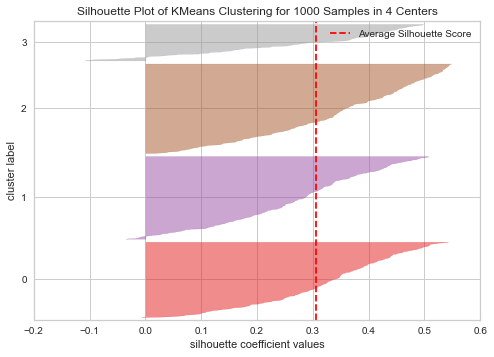

In [219]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import SilhouetteVisualizer

model3 = KMeans(n_clusters=4, random_state=42)
visualizer = SilhouetteVisualizer(model3)

visualizer.fit(rfm_normalized)    # Fit the data to the visualizer
visualizer.poof();

The Silhouette score is based on both very good clustering within itself and the maximum possible distance from other clusters.Three different methods were used to determine the number of clusters. Finally, the optimum number of clusters was selected by considering the Silhouette score. Therefore k=4.

### Model Fitting

The K-Means Algorithm must be fitted to the optimum number of clusters we have determined.

In [278]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_normalized)
y_kmeans = kmeans.predict(rfm_normalized)

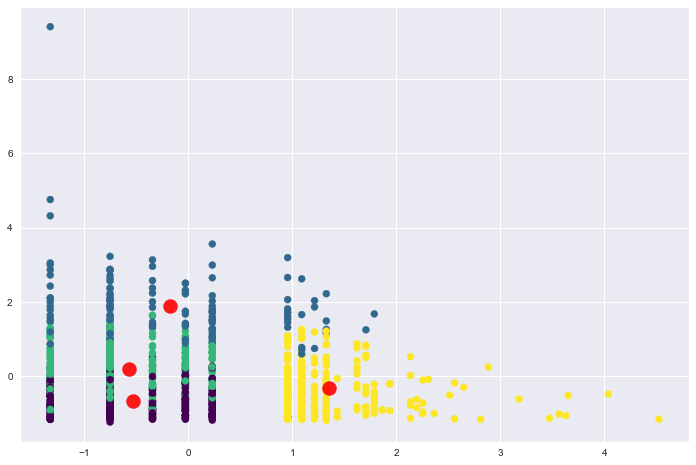

In [279]:
# Draw a scatter plot and select cluster centers.
plt.figure(figsize=(12,8))
plt.scatter(rfm_normalized.iloc[:, 0], rfm_normalized.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9);

In [280]:
# Adding cluster column to rfm data frame
cluster_labels = kmeans.labels_
rfm_k4 = rfm.assign(Cluster=cluster_labels)
rfm_k4.head(10)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Level,Cluster
customerNumber,,,,,,,,,
1,3,465,162812.00,3,1,4,8,Middle,2
2,3,425,33578.00,3,1,1,5,Low,0
3,11,1351,178882.00,1,4,4,9,High,1
4,2,423,72461.00,4,1,3,8,Middle,0
5,11,436,38888.00,1,1,1,3,Low,3
6,2,418,42236.00,4,1,1,6,Low,0
7,3,485,70642.00,3,2,3,8,Middle,0
8,4,621,85635.00,3,3,3,9,High,2
9,2,541,48290.00,4,2,1,7,Middle,0


In [281]:
grouped = rfm_k4.groupby(['Cluster'])
avg_df=grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)
avg_df

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          2.70    491.50      50542.60   315
1          4.40   1606.30     204071.20   129
2          2.60    702.40      93101.80   292
3         13.80    575.20      71160.70   264

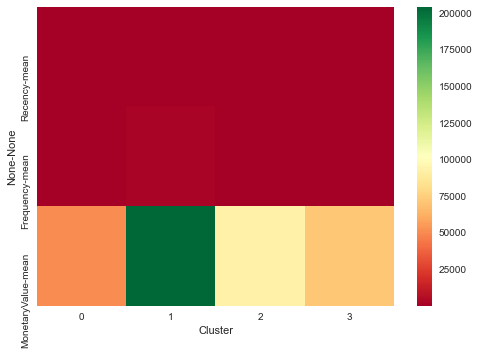

In [282]:
sns.heatmap(avg_df.iloc[:,:-1].T, cmap="RdYlGn");

In [287]:
def rfm_level(df):
    if df['RFM_Score'] >= 11:
        return 'Platinum'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 11)):
      return "Gold"
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 8)):
        return 'Bronze'
    else:
        return 'Silver'

rfm_k4['RFM_Segment'] = rfm_k4.apply(rfm_level, axis=1)

In [288]:
print(rfm_k4.sample(19))

                Recency  Frequency  MonetaryValue  R  F  M  RFM_Score  \
customerNumber                                                          
528                   5        697       45932.00  2  3  1          6   
279                   2        409       26565.00  4  1  1          6   
866                  12        433       39010.00  1  1  1          3   
862                   1        478       59805.00  4  2  2          8   
5                    11        436       38888.00  1  1  1          3   
208                   9        444       40571.00  2  1  1          4   
394                   2        534       44647.00  4  2  1          7   
83                    2        732       55082.00  4  3  2          9   
772                   5       1271      172135.00  2  4  4         10   
144                   1        432       18855.00  4  1  1          6   
19                    9        546       42842.00  2  2  1          5   
548                  10        642       97236.00  

In [286]:
cluster2= rfm_k4[(rfm_k4["RFM_Level"]=="High") & (rfm_k4.Cluster==2)].Recency.count()/rfm_k4[rfm_k4.Cluster==2].Recency.count()
cluster3= rfm_k4[(rfm_k4["RFM_Level"]=="Low") & (rfm_k4.Cluster==3)].Recency.count()/rfm_k4[rfm_k4.Cluster==3].Recency.count()
cluster1= rfm_k4[(rfm_k4["RFM_Level"]=="Top Class") & (rfm_k4.Cluster==1)].Recency.count()/rfm_k4[rfm_k4.Cluster==1].Recency.count()
cluster0= rfm_k4[(rfm_k4["RFM_Level"]=="Middle") & (rfm_k4.Cluster==0)].Recency.count()/rfm_k4[rfm_k4.Cluster==0].Recency.count()

print("clustering success for cluster0 is {:.2f} \n clustering success for cluster1 is {:.2f}\n clustering success for cluster2 is {:.2f}\n clustering success for cluster3 is {:.2f}".format(cluster0, cluster1, cluster2, cluster3))

clustering success for cluster0 is 0.51 
 clustering success for cluster1 is 0.60
 clustering success for cluster2 is 0.60
 clustering success for cluster3 is 0.68


In [289]:
rfm_k4.groupby("Cluster")["RFM_Level"].value_counts()

Cluster  RFM_Level
0        Middle       162
         Low          141
         High          12
1        Top Class     78
         High          50
         Middle         1
2        High         174
         Top Class     64
         Middle        52
         Low            2
3        Low          179
         Middle        64
         High          21
Name: RFM_Level, dtype: int64

In [67]:
factura_df.head()

,customerNumber,purchaseDate,branchNumber,articleNumber,quantity,discountOnRecommendedRetailPrice[%],purchaseAmount
0,557,2021-01-04,19,6013,1.00,0.00,17.24
1,557,2021-01-04,19,6663,2.00,8.37,94.96
2,189,2021-01-04,17,2982,2.00,32.23,59.96
3,490,2021-01-04,19,10658,1.00,25.04,24.05
4,896,2021-01-04,36,14971,3.00,0.00,26.69


In [299]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(rfm_normalized)
y_kmeans = kmeans.predict(rfm_normalized)

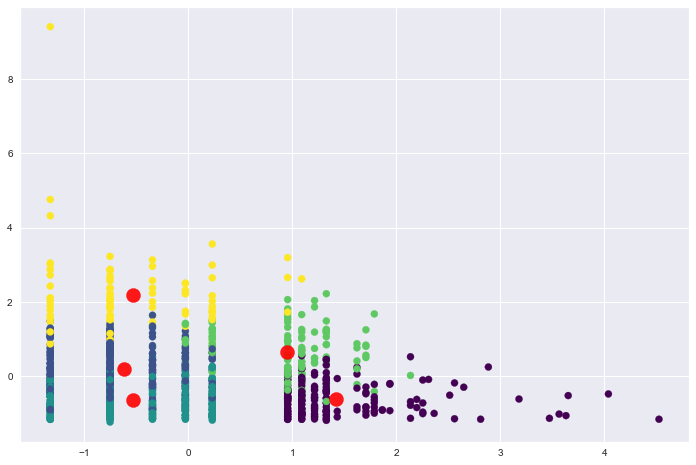

In [300]:
# Draw a scatter plot and select cluster centers.
plt.figure(figsize=(12,8))
plt.scatter(rfm_normalized.iloc[:, 0], rfm_normalized.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9);

In [301]:
# Adding cluster column to rfm data frame
cluster_labels = kmeans.labels_
rfm_k5 = rfm.assign(Cluster=cluster_labels)
rfm_k5.head(10)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Level,Cluster
customerNumber,,,,,,,,,
1,3,465,162812.00,3,1,4,8,Middle,1
2,3,425,33578.00,3,1,1,5,Low,2
3,11,1351,178882.00,1,4,4,9,High,3
4,2,423,72461.00,4,1,3,8,Middle,2
5,11,436,38888.00,1,1,1,3,Low,0
6,2,418,42236.00,4,1,1,6,Low,2
7,3,485,70642.00,3,2,3,8,Middle,2
8,4,621,85635.00,3,3,3,9,High,1
9,2,541,48290.00,4,2,1,7,Middle,2


In [302]:
grouped = rfm_k5.groupby(['Cluster'])
avg_df=grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)
avg_df

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         15.00    504.40      56372.50   188
1          2.50    706.20      93008.30   280
2          2.70    493.60      50843.00   319
3          9.50    853.10     121259.10   127
4          2.90   1867.70     232082.40    86

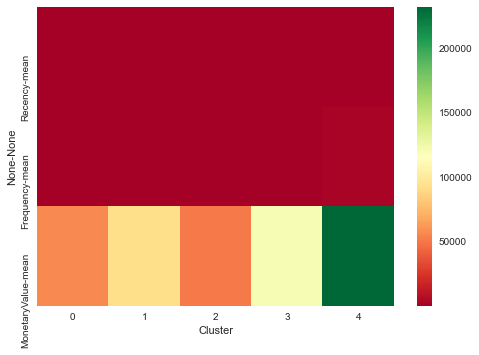

In [303]:
sns.heatmap(avg_df.iloc[:,:-1].T, cmap="RdYlGn");

In [304]:
def rfm_level(df):
    if df['RFM_Score'] >= 11:
        return 'Platinum'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 11)):
      return "Gold"
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 8)):
        return 'Bronze'
    else:
        return 'Silver'

rfm_k5['RFM_Segment'] = rfm_k5.apply(rfm_level, axis=1)

In [306]:
print(rfm_k5.sample(19))

                Recency  Frequency  MonetaryValue  R  F  M  RFM_Score  \
customerNumber                                                          
83                    2        732       55082.00  4  3  2          9   
482                   1       1696      198978.00  4  4  4         12   
566                   9        614       53723.00  2  3  2          7   
312                   2        431       32521.00  4  1  1          6   
751                   5        708       52385.00  2  3  2          7   
213                   1       1053      112098.00  4  4  4         12   
569                  10        420       42417.00  1  1  1          3   
890                   5        695       54209.00  2  3  2          7   
166                   2        684       67975.00  4  3  2          9   
268                   3        487       40586.00  3  2  1          6   
984                   2       1051      108169.00  4  4  4         12   
438                   2        539       52614.00  

In [308]:
rfm_k5.groupby("Cluster")["RFM_Level"].value_counts()

Cluster  RFM_Level
0        Low          175
         Middle        13
1        High         163
         Top Class     68
         Middle        49
2        Middle       164
         Low          142
         High          13
3        High          63
         Middle        53
         Top Class      6
         Low            5
4        Top Class     68
         High          18
Name: RFM_Level, dtype: int64

In [ ]:
cluster2= rfm_k4[(rfm_k4["RFM_Level"]=="High") & (rfm_k4.Cluster==2)].Recency.count()/rfm_k4[rfm_k4.Cluster==2].Recency.count()
cluster3= rfm_k4[(rfm_k4["RFM_Level"]=="Low") & (rfm_k4.Cluster==3)].Recency.count()/rfm_k4[rfm_k4.Cluster==3].Recency.count()
cluster1= rfm_k4[(rfm_k4["RFM_Level"]=="Top Class") & (rfm_k4.Cluster==1)].Recency.count()/rfm_k4[rfm_k4.Cluster==1].Recency.count()
cluster0= rfm_k4[(rfm_k4["RFM_Level"]=="Middle") & (rfm_k4.Cluster==0)].Recency.count()/rfm_k4[rfm_k4.Cluster==0].Recency.count()

print("clustering success for cluster0 is {:.2f} \n clustering success for cluster1 is {:.2f}\n clustering success for cluster2 is {:.2f}\n clustering success for cluster3 is {:.2f}".format(cluster0, cluster1, cluster2, cluster3))